In [ ]:
# Importing required packages
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [ ]:
# Loading 'genomics_ood' dataset
train_seq, train_label = tfds.as_numpy(tfds.load('genomics_ood', split='train[:10%]', batch_size=-1, as_supervised=True))
test_seq, test_label = tfds.as_numpy(tfds.load('genomics_ood', split='test[:1%]', batch_size=-1, as_supervised=True))

In [ ]:
# Defining function to convert the string tensor into a tensor with one-hot-encoded sequence
def onehotify(tensor):
  vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'0'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
  split = tf.strings.bytes_split(tensor)
  labels = tf.cast(tf.strings.to_number(split), tf.uint8)
  onehot = tf.one_hot(labels, 4)
  onehot = tf.reshape(onehot, (-1,))
  return onehot


In [ ]:
# Preparing training sequences and their labels
gen_train_seq = tf.data.Dataset.from_tensor_slices(train_seq)
# Applying given above function on training sequences
gen_train_seq = gen_train_seq.map(onehotify)

gen_train_label = tf.data.Dataset.from_tensor_slices(train_label)
# Applying one-hot-encoding on training labels
gen_train_label = gen_train_label.map(lambda t: tf.one_hot(t, 10))

# Zipping together sequences and their labels
train_ds = tf.data.Dataset.zip((gen_train_seq, gen_train_label))
train_ds = train_ds.batch(128)
train_ds = train_ds.shuffle(buffer_size=128)

In [ ]:
# Preparing testing sequences and their labels
gen_test_seq = tf.data.Dataset.from_tensor_slices(test_seq)
# Applying given above function on test sequences
gen_test_seq = gen_test_seq.map(onehotify)

gen_test_label = tf.data.Dataset.from_tensor_slices(test_label)
# Applying one-hot-encoding on test labels
gen_test_label = gen_test_label.map(lambda t: tf.one_hot(t, 10))

# Zipping together sequences and their labels
test_ds = tf.data.Dataset.zip((gen_test_seq, gen_test_label))
test_ds = test_ds.batch(128)
test_ds = test_ds.shuffle(buffer_size=128)

In [ ]:
# Custom Model
class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = SimpleDense(256, activation = tf.nn.sigmoid)
        self.dense2 = SimpleDense(256, activation = tf.nn.sigmoid)
        self.out = SimpleDense(10, activation = tf.nn.softmax)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        out = self.out(x)
        return out



# Custom Layer
class SimpleDense(tf.keras.layers.Layer):

    def __init__(self, units, activation):
        super(SimpleDense, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape): 
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

    def call(self, inputs): 
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
#tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_ds
test_dataset = test_ds

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.1299579326923077
Epoch: 1 starting with accuracy 0.3487079326923077
Epoch: 2 starting with accuracy 0.3269981971153846
Epoch: 3 starting with accuracy 0.359375
Epoch: 4 starting with accuracy 0.3284254807692308
Epoch: 5 starting with accuracy 0.3557692307692308
Epoch: 6 starting with accuracy 0.3733473557692308
Epoch: 7 starting with accuracy 0.37545072115384615


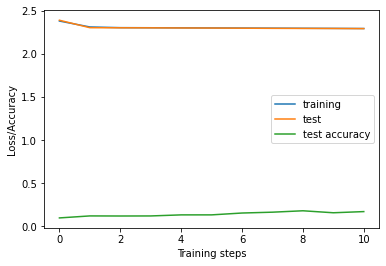

In [ ]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()